**SUMMARY**

Checks the relationship between the Bechedel Test outcome vs existing and potential features.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from ast import literal_eval
from typing import List

from math import ceil, floor

In [2]:
sns.set(style="darkgrid")

# Load Data

In [3]:
# Define cols
y_col, key_col = "bt_pass", "imdbid"

In [4]:
df = pd.read_csv("../data/raw.csv")
print(df.shape)

(7271, 22)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7271 entries, 0 to 7270
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   title                       7271 non-null   object 
 1   year                        7271 non-null   int64  
 2   bt_score                    7271 non-null   int64  
 3   dubious                     7271 non-null   int64  
 4   imdbid                      7271 non-null   int64  
 5   tmdbId                      7271 non-null   int64  
 6   genres                      7271 non-null   object 
 7   popularity                  7271 non-null   float64
 8   production_companies        7271 non-null   object 
 9   production_countries        7271 non-null   object 
 10  release_date                7271 non-null   object 
 11  revenue                     7271 non-null   float64
 12  vote_average                7271 non-null   float64
 13  vote_count                  7271 

# Feature Schema

In [6]:
# TODO: add oscars data

# Categorical features
cat_cols = [
    "genres",
    "production_companies", # TODO: too sparse to use currently
    "production_countries", # TODO: too sparse to use currently
]

# Numerical features
num_cols = [
    "vote_average", # TODO: weight by count?,
    "vote_count",
    "cast_female_representation", # TODO: add male/NB representation?,
    "crew_female_representation", # TODO: add male/NB representation?
    "budget",
    "popularity",
    "revenue",
]

# Date features
date_cols = [
    "year",
    "release_date" #TODO: convert to year? or year/month?
]
    
# Either target-related, keys or raw features to ignore
ignore_cols = [
    "bt_pass",
    "title",
    "dubious",
    "bt_score",
    "imdbid",
    "tmdbId",
    "cast",
    "crew",
    "cast_gender",
    "crew_gender"
]

# Check we didn't miss any columns
assert sorted(cat_cols + num_cols + date_cols + ignore_cols) == sorted(df.columns)

In [7]:
def get_unique_tags(col: pd.Series) -> List:
    """Gets a list of unique values across a Pandas column of lists"""
    
    all_tags = [literal_eval(sublist) for sublist in col.unique().tolist()]

    unique_tags = set([
        tag
        for tag_list in all_tags
        for tag in tag_list
    ])
    
    return list(unique_tags)

# Plot Features

## Categorical Features (Genre)

In [8]:
genres = get_unique_tags(df["genres"])

# Create binary indicator for presence of each genre tag in movie
for genre in genres:
    df[f"genre__{genre}"] = df["genres"].apply(lambda x: 1 if genre in x else 0)

In [9]:
# Get counts per genre

df_plot = pd.DataFrame(
    [(genre, 
      (df[f"genre__{genre}"] == 1).sum(), 
      df.loc[df[f"genre__{genre}"] == 1, y_col].sum()) for genre in genres],
    columns = ["genre", "num_total", "num_pass"]
)

df_plot['pass_rate'] = df_plot['num_pass'] / df_plot['num_total']

df_plot = df_plot.sort_values('pass_rate', ascending=False)

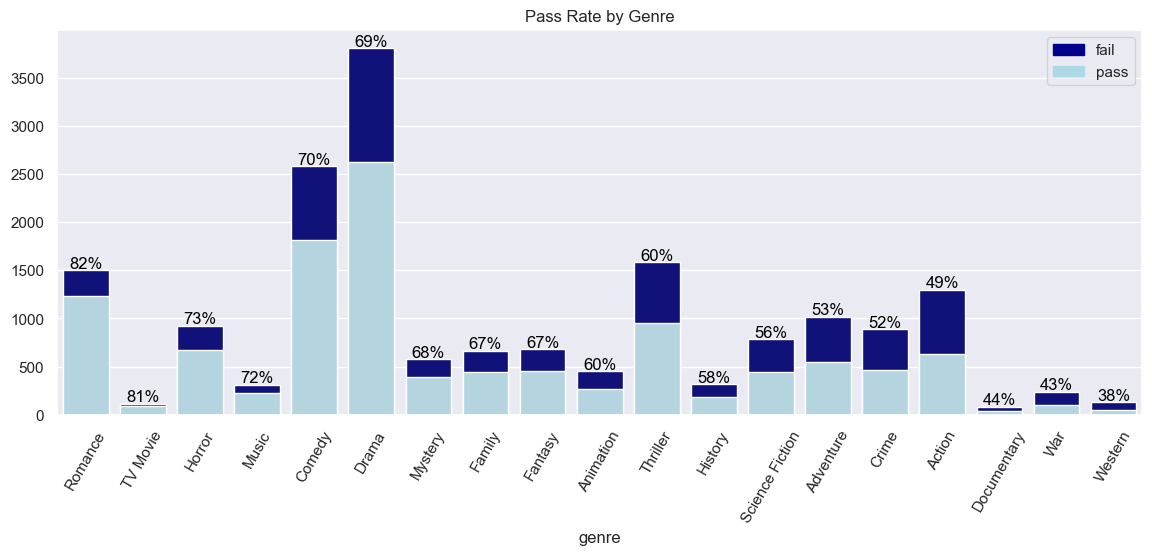

In [10]:
plt.figure(figsize=(14, 5))

bar1 = sns.barplot(x="genre",  y="num_total", data=df_plot, color='darkblue')
bar2 = sns.barplot(x="genre", y="num_pass", data=df_plot, color='lightblue')

# Add legend
top_bar = mpatches.Patch(color='darkblue', label='fail')
bottom_bar = mpatches.Patch(color='lightblue', label='pass')
plt.legend(handles=[top_bar, bottom_bar])

plt.xticks(rotation = 60)

# Add pass rate as bar annotation
for index, row in df_plot.iterrows():
    bar1.text(
        row.genre,
        row.num_total + 20,
        f"{row.pass_rate:.0%}",
        color='black',
        ha="center"
    )

plt.ylabel("No. Movies")
plt.ylabel("")
plt.title("Pass Rate by Genre")
plt.show()

# Numerical features

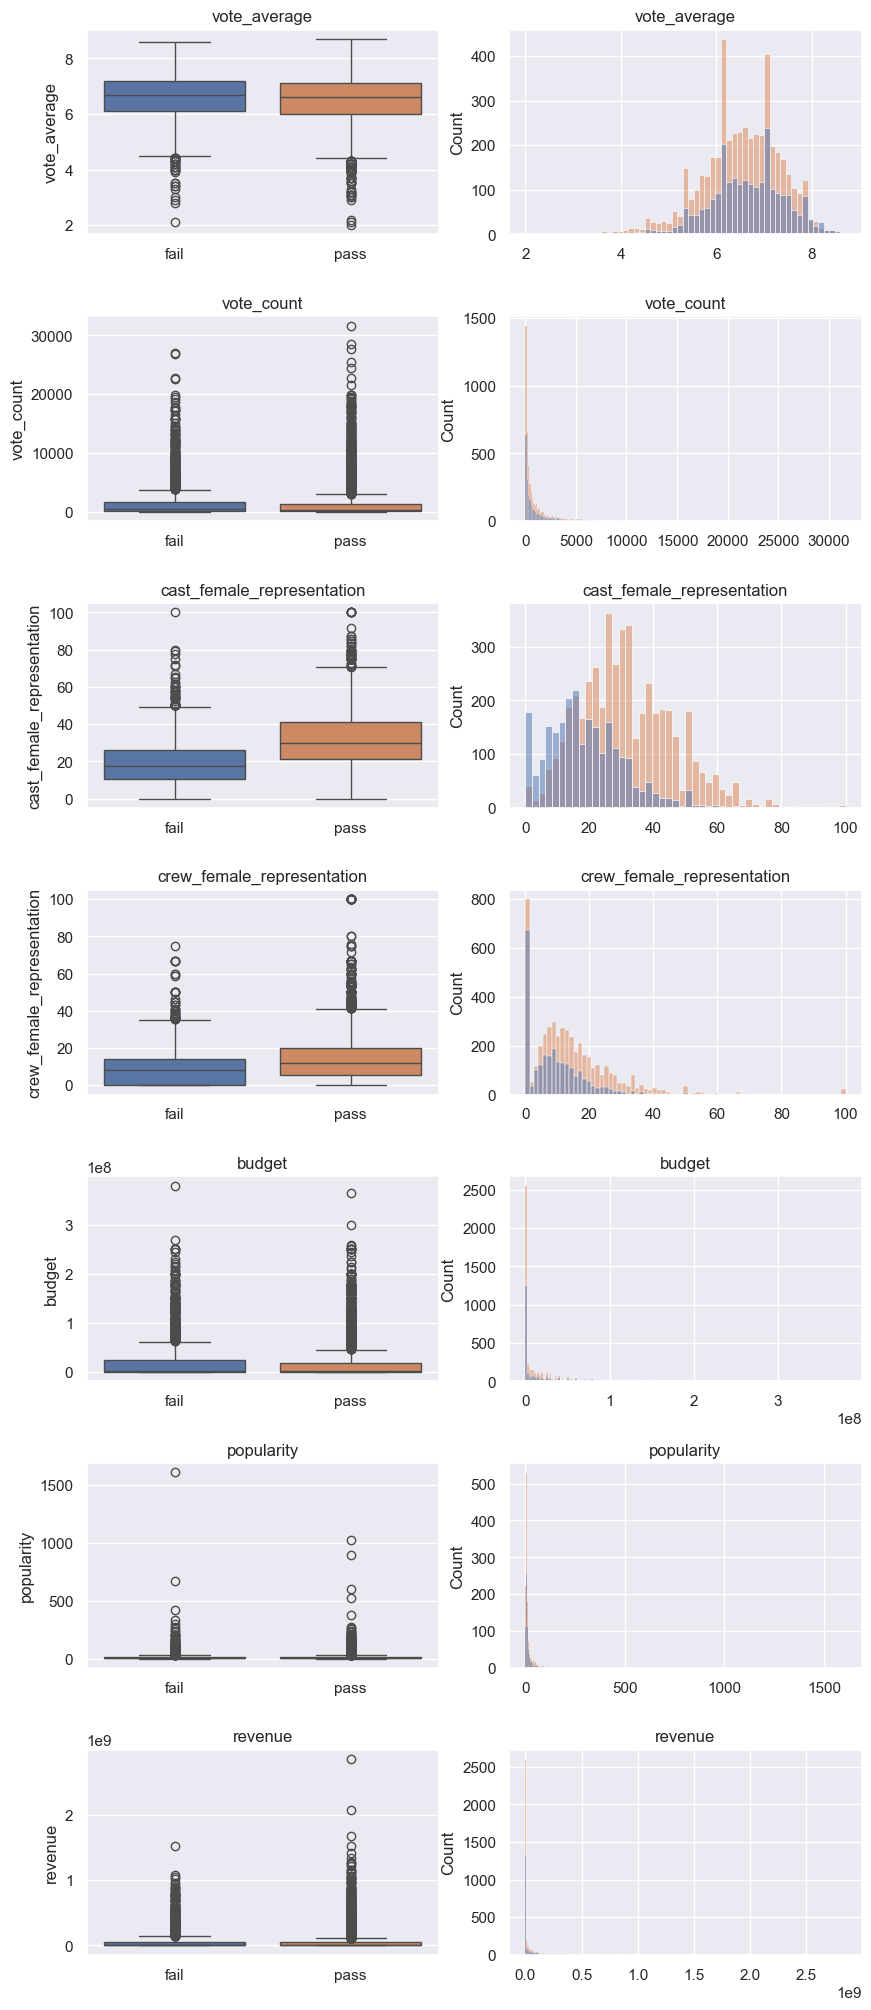

In [11]:
fig, ax = plt.subplots(len(num_cols), 2, figsize = (10, 25))
plt.subplots_adjust(hspace=0.4)

for i, col in enumerate(num_cols):

    # Boxplot of pass rate against each numeric feature
    sns.boxplot(y=col, x=y_col, data=df, orient='v', ax=ax[i, 0], hue=y_col, legend=False)
    ax[i, 0].set_title(col)
    ax[i, 0].set_xlabel("")
    ax[i, 0].set_xticks([0, 1], ["fail", "pass"])
    # Histogram of feature values
    sns.histplot(df, x=col, hue=y_col, ax=ax[i, 1], legend=False, alpha=0.5)
    ax[i, 1].set_title(col)
    ax[i, 1].set_xlabel("")

plt.show()

In [12]:
# Right-skewed features
skew_cols = [
    "revenue",
    "popularity",
    "budget",
]

In [13]:
for col in skew_cols:
    print(
        col,
        "---",
        f"Count of zeroes: {(df[col] == 0).sum()},",
        f"Count of negative vals: {(df[col] < 0).sum()},",
        f"Min excl. zeroes: {df[df[col] > 0][col].min()}",
    )

revenue --- Count of zeroes: 2922, Count of negative vals: 0, Min excl. zeroes: 2.0
popularity --- Count of zeroes: 0, Count of negative vals: 0, Min excl. zeroes: 0.6
budget --- Count of zeroes: 3055, Count of negative vals: 0, Min excl. zeroes: 1.0


In [14]:
# Replace zeroes with 0.5 and log-transform
for col in skew_cols:
    df[f"{col}_log"] = np.where(df[col] == 0, np.log(0.5), np.log(df[col]))

/Users/shreena/Library/Caches/pypoetry/virtualenvs/bechdel-test-predictor-z04Sa2tT-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/shreena/Library/Caches/pypoetry/virtualenvs/bechdel-test-predictor-z04Sa2tT-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


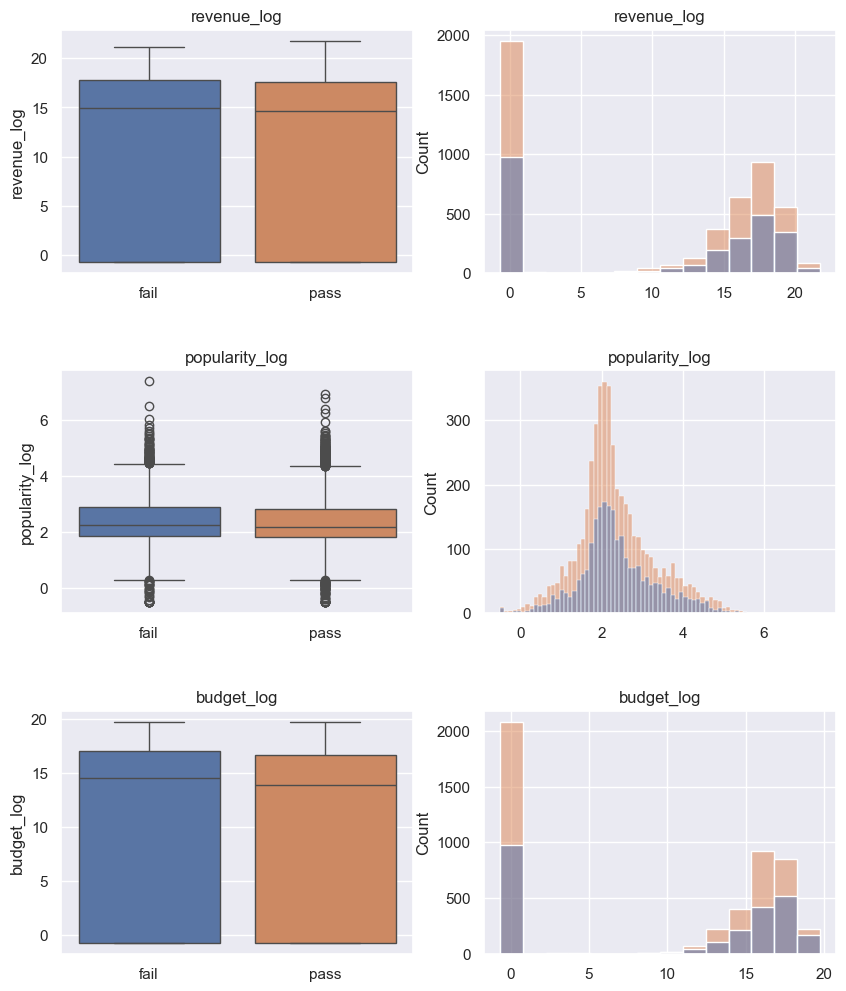

In [15]:
# Plot log-transformed cols

log_cols = [f"{col}_log" for col in skew_cols]

fig, ax = plt.subplots(len(log_cols), 2, figsize = (10, 12))
plt.subplots_adjust(hspace=0.4)

for i, col in enumerate(log_cols):

    # Boxplot of pass rate against each numeric feature
    sns.boxplot(y=col, x=y_col, data=df, orient='v', ax=ax[i, 0], hue=y_col, legend=False)
    ax[i, 0].set_title(col)
    ax[i, 0].set_xlabel("")
    ax[i, 0].set_xticks([0, 1], ["fail", "pass"])
    # Histogram of feature values
    sns.histplot(df, x=col, hue=y_col, ax=ax[i, 1], legend=False, alpha=0.5)
    ax[i, 1].set_title(col)
    ax[i, 1].set_xlabel("")

plt.show()

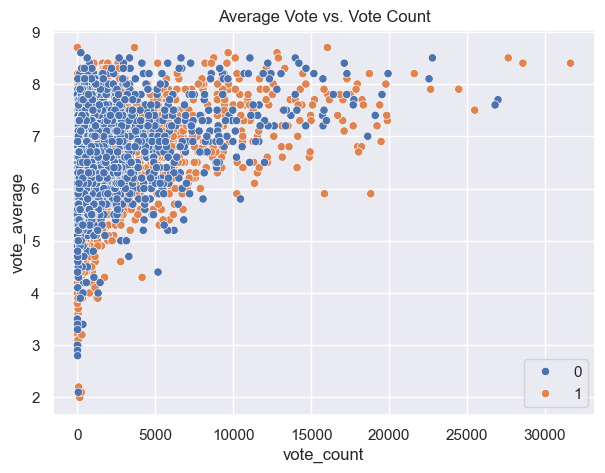

In [16]:
# Should we normalize vote_average by vote_count?

fig, ax = plt.subplots(1, 1, figsize = (7, 5))
sns.scatterplot(x="vote_count", y="vote_average", data=df, hue=y_col, ax=ax)

ax.set_title("Average Vote vs. Vote Count")
ax.legend(loc="lower right")

plt.show()

In [17]:
# No obvious trend for now

# Date Features

In [18]:
df["release_year"] = df['release_date'].str.split("/").str[-1].apply(int)

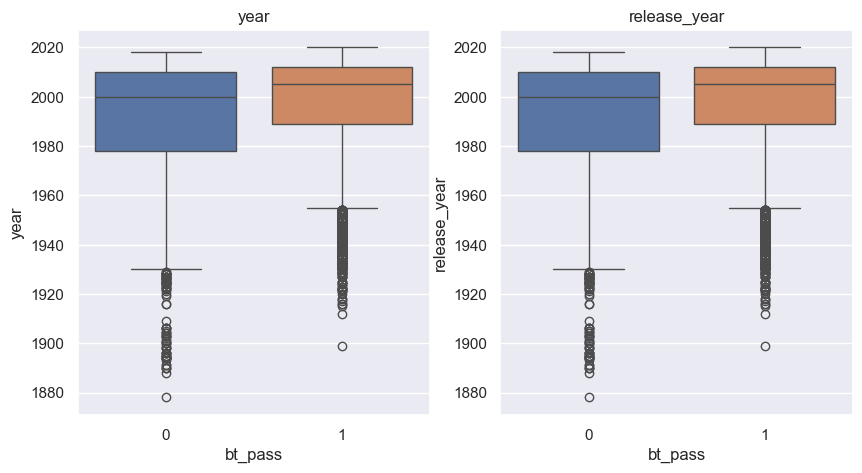

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.boxplot(y="year", x=y_col, data=df, orient='v', ax=ax[0], hue=y_col, legend=False)
ax[0].set_title("year")
sns.boxplot(y="release_year", x=y_col, data=df, orient='v', ax=ax[1], hue=y_col, legend=False)
ax[1].set_title("release_year")

plt.show()

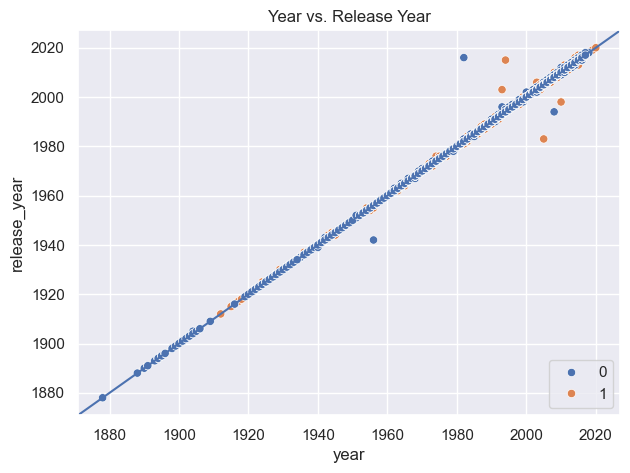

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
sns.scatterplot(x="year", y="release_year", data=df, hue=y_col, ax=ax, legend=True)

ax.set_title("Year vs. Release Year")
ax.legend(loc="lower right")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)

plt.show()

In [21]:
# Seems like 'year' is equivalent to release_year in most cases. Just use year for now.

# Female pronouns in title

In [22]:
female_pronouns = ["she", "her", "her's", "women", "woman", "lady", "lady's"]

In [23]:
df["pronouns_in_title"] = df["title"].str.lower().apply(lambda x: any(p for p in female_pronouns if p in x.split(" ")))

In [24]:
df["pronouns_in_title"].value_counts()

pronouns_in_title
False    7173
True       98
Name: count, dtype: int64

In [25]:
pd.crosstab(df["pronouns_in_title"], df[y_col], normalize="index")

bt_pass,0,1
pronouns_in_title,,
False,0.342535,0.657465
True,0.153061,0.846939
